# Generate 1D bathymetry profile of SSA rock
Take 1D transect of Asilomar 2022 SSA rock for use in wave dissipation Matlab code by Johanna Rosman.

In [56]:
# Imports
import os
import glob
import numpy as np
import pandas as pd
import xarray as xr
import statsmodels.api as sm
from scipy.io import loadmat, savemat
from datetime import datetime as DT
import cmocean
from pyproj import Proj
import matplotlib.pyplot as plt
import salem
import utm
# Interactive plots
%matplotlib widget 
from roxsi_pyfuns import stats as rps

# Paths, files
rootdir = r'/media/mikapm/T7 Shield/ROXSI/Asilomar2022/SmallScaleArray/'
bathydir = os.path.join(rootdir, 'Bathy')
fn_bathy = os.path.join(bathydir, 'Asilomar_2022_SSA_bathy_updated_50cm.nc')
dsb = xr.decode_cf(xr.open_dataset(fn_bathy, decode_coords='all'))

# Read large-scale array mooring locations table
fn_lsa = os.path.join(rootdir, 'ROXSI2022_LSA_mooring_locations.csv')
df_lsa = pd.read_csv(fn_lsa).set_index('Mooring')
# Fill missing values w/ NaN
df_lsa = df_lsa.replace(9999999999.0, np.nan)

In [82]:
# Plot bathymetry overlaid on top of Google Earth image
bathy = True # Set to false to only show satellite image
c3 = True # Set to true to mark C3 SSA mooring
fig, ax = plt.subplots(figsize=(7,6), constrained_layout=True)# nrows=2, height_ratios=[4,1])
# Set zoom in region
x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
y0 = dsb.C3.attrs['y_loc'].round()

utm_zone = 10 # Standard UTM zone number (northern hemisphere)
FFX = 0 # Fudge Factor in x (East)
FFY = -5 # Fudge Factor in y (North) -5 seems to work well
IN = [594490.19 + FFX, 4053805.82 + FFY] # Inshore North
ON = [594478.45 + FFX, 4053815.67 + FFY] # Offshore North
OS = [594470.48 + FFX, 4053808.93 + FFY] # Offshore South
IS = [594477.74 + FFX, 4053799.02 + FFY] # Inshore South
BUFFERREGION = 10  # size of buffer region beyond coords of subsurface buys
eastingMin = min(np.array([IN[0],ON[0],OS[0],IS[0]]) - BUFFERREGION)
eastingMax = max(np.array([IN[0],ON[0],OS[0],IS[0]]) + BUFFERREGION)
northingMin = min(np.array([IN[1],ON[1],OS[1],IS[1]]) - BUFFERREGION)
northingMax = max(np.array([IN[1],ON[1],OS[1],IS[1]]) + BUFFERREGION)
# Define background boundaries for plot (P)
buffer = 140 # Buffer distance (m)
latMinP, lonMinP = utm.to_latlon(eastingMin-buffer+120, northingMin-buffer, 
                                 zone_number=utm_zone, northern=True)
latMaxP, lonMaxP = utm.to_latlon(eastingMax+buffer+120, northingMax+buffer, 
                                 zone_number=utm_zone, northern=True)
# If you need to do a lot of maps you might want
# to use an API key and set it here with key='YOUR_API_KEY'
g = salem.GoogleVisibleMap(x=[lonMinP, lonMaxP], y=[latMinP, latMaxP],
                           scale=2,  # scale is for more details
                           maptype='satellite',
                           )
# The google static image is a standard rgb image
ggl_img = g.get_vardata()
# Make a map of the same size as the image (no country borders)
sm = salem.Map(g.grid, factor=2, countries=False)
sm.set_shapefile()  # add the glacier outlines
sm.set_rgb(ggl_img)  # add the background rgb image
sm.set_scale_bar(location=(0.13, 0.12), color='white')  # add scale
sm.set_lonlat_contours(max_nticks=6)
sm.visualize(ax=ax)  # plot it

# 0.5-m grid
vmin = -10
vmax = 0
xmin = x0 - 150
xmax = x0 + 280
ymin = y0 - 280
ymax = y0 + 320
dsbc = dsb.sel(x=slice(xmin,xmax), y=slice(ymin,ymax))
# Define UTM WGS84 projection for SSA grid
proj_utm = Proj(proj='utm', zone=utm_zone, ellps='WGS84', 
                preserve_units=False)
Xsu, Ysu, _, _ = utm.from_latlon(dsbc.lat.values.squeeze(), dsbc.lon.values.squeeze())
# Transform SSA grid coordinates to google map projection
xx, yy = sm.grid.transform(Xsu, Ysu, crs=proj_utm)
# Plot bathy if flag is true
if bathy:
    levels = np.linspace(-12, 0, 13) # Contour levels to show
    grid = ax.contourf(xx, yy, dsbc.z_msl.where(dsbc.z_msl<0), cmap=cmocean.cm.deep_r, levels=levels)
    # Colorbar on right
    cax = ax.inset_axes([1.01, 0.00, 0.05, 1.0], transform=ax.transAxes)
    cbar = fig.colorbar(grid, cax=cax)
    cbar.ax.set_title(r'  $z$ [m]')
    if c3:
        # Mark SSA center mooring. Convert to UTM
        xc3, yc3 = proj_utm(dsbc.C3.longitude, dsbc.C3.latitude)
        # Convert UTM coordinates to google image projection
        xc3, yc3 = sm.grid.transform(xc3, yc3, crs=proj_utm)
        ax.scatter(xc3, yc3, marker='o', s=120, facecolors='none', edgecolors='gold')

# Mark large-scale array mooring locations
for row in df_lsa.iterrows():
    if row[1]['Array'] == 'Asilomar':
        # Plot mooring location
        lon = row[1]['Deployed longitude']
        lat = row[1]['Deployed latitude']
        # Convert to UTM
        xp, yp = proj_utm(lon, lat)
        # Convert UTM coordinates to google image projection
        xp, yp = sm.grid.transform(xp, yp, crs=proj_utm)
        ax.scatter(xp, yp, marker='+', color='r', s=50)

# Save figure
if not bathy and not c3:
    fn_fig = os.path.join(bathydir, 'bathy_sat_lsa.png')
elif bathy and not c3:
    fn_fig = os.path.join(bathydir, 'bathy_sat_lsa_bathy.png')
elif bathy and c3:
    fn_fig = os.path.join(bathydir, 'bathy_sat_lsa_bathy_c3.png')
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=600)
plt.close()

print('Done.')

Done.


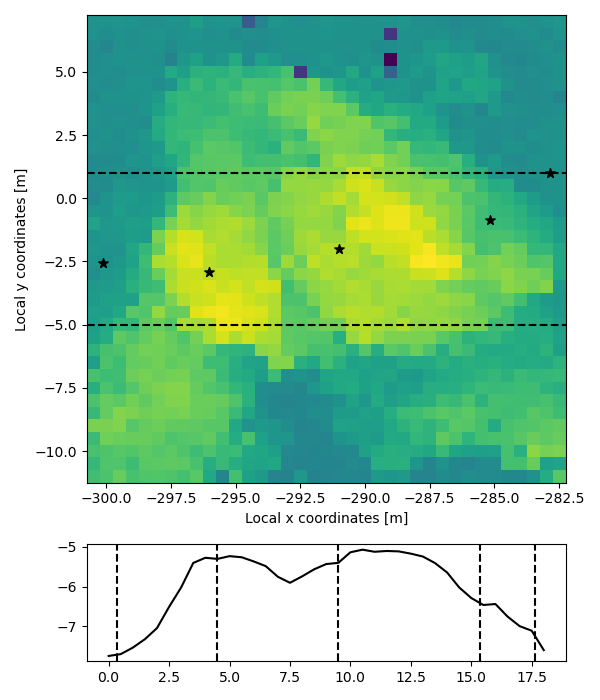

x_c1-xmin:  0.3543679822445256
x_c2-xmin:  4.48718684602386
x0-xmin:  9.5
x_c5-xmin:  15.3428594353839
x_c6-xmin:  17.64202826346542


In [15]:
# Plot bathymetry
fig, axes = plt.subplots(figsize=(6,7), nrows=2, height_ratios=[4,1])
# Set zoom in region
x0 = dsb.C3.attrs['x_loc'].round() # C3 mooring location in the middle
y0 = dsb.C3.attrs['y_loc'].round()
xmin = x0 - 9.5
xmax = x0 + 8.5
ymin = y0 - 9
ymax = y0 + 9
dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin, ymax)).plot.pcolormesh(ax=axes[0], 
                                                                        add_colorbar=False,
                                                                        )
# Mark C1, C3 & C6 moorings
axes[0].scatter(x0, y0, marker='*', color='k', s=50) # C3
x_c1, y_c1 = (dsb.C1.attrs['x_loc'], dsb.C1.attrs['y_loc'])
axes[0].scatter(x_c1, y_c1, marker='*', color='k', s=50) # C1
x_c2, y_c2 = (dsb.C2.attrs['x_loc'], dsb.C2.attrs['y_loc'])
axes[0].scatter(x_c2, y_c2, marker='*', color='k', s=50) # C1
x_c5, y_c5 = (dsb.C5.attrs['x_loc'], dsb.C5.attrs['y_loc'])
axes[0].scatter(x_c5, y_c5, marker='*', color='k', s=50) # C1
x_c6, y_c6 = (dsb.C6.attrs['x_loc'], dsb.C6.attrs['y_loc'])
axes[0].scatter(x_c6, y_c6, marker='*', color='k', s=50) # C6
# Take 1D transect and plot on bottom row
ymin_t = y0 - 3
ymax_t = y0 + 3
transect = dsb.z_msl.sel(x=slice(xmin, xmax), y=slice(ymin_t, ymax_t)).mean(dim='y')
# Make x axis for transect
xt = transect.x.values - xmin
ax=axes[1].plot(xt, transect.values, color='k')
# Mark boundaries of transect
axes[0].axhline(ymin_t, color='k', ls='--')
axes[0].axhline(ymax_t, color='k', ls='--')
# Mark mooring locations with vertical lines
axes[1].axvline(x_c1-xmin, color='k', ls='--')
axes[1].axvline(x_c2-xmin, color='k', ls='--')
axes[1].axvline(x0-xmin, color='k', ls='--')
axes[1].axvline(x_c5-xmin, color='k', ls='--')
axes[1].axvline(x_c6-xmin, color='k', ls='--')

plt.tight_layout()
plt.show()

print('x_c1-xmin: ', x_c1-xmin)
print('x_c2-xmin: ', x_c2-xmin)
print('x0-xmin: ', x0-xmin)
print('x_c5-xmin: ', x_c5-xmin)
print('x_c6-xmin: ', x_c6-xmin)

Save 1D transect to .mat file

In [62]:
# Save to .mat
fn_mat = os.path.join(bathydir, 'transect_1d.mat')
if not os.path.isfile(fn_mat):
    print('Saving to .mat')
    # Note: positive z
    savemat(fn_mat, {'x': xt, 'z': (transect - transect.min().item()).values})

Saving to .mat


Generate .mat file with boundary values from C1 Signature AST spectra for dissipation computation Matlab script.

In [6]:
ser = '103088'
mid = 'C1'
sig_root = os.path.join(rootdir, 'Signatures', 'Level1')
# Spectra netcdf directory
specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
fn_nc_spec = os.path.join(specdir, 'Asilomar_2022_SSA_Signature_{}_spec_AST.nc'.format(ser))
dss = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))

# Get variables needed for boundary values
ds_c1 = np.array([pd.Timestamp(t).strftime('%Y%m%d') for t in dss.time.values])
ts_c1 = np.array([pd.Timestamp(t).strftime('%H%M') for t in dss.time.values])
Hrms_c1 = 0.5 * np.sqrt(2) * dss.Hm0.values # RMS wave heights
h_c1 = dss.depth_loc.values # Local water depths
Tp_c1 = dss.Tp_Y95.values

# Save as .mat
fn_mat_vars = os.path.join(bathydir, 'C1_Sig_input.mat')
if not os.path.isfile(fn_mat_vars):
    print('Saving to .mat')
    # Note: positive z
    savemat(fn_mat_vars, {'ds_c1':ds_c1, 'ts_c1':ts_c1, 'Hrms_c1':Hrms_c1, 
                          'h_c1':h_c1, 'Tp_c1':Tp_c1})

Combine Matlab output (12000 .mat files...) into one xr.Dataset and save as netcdf.

In [7]:
# Directory with Matlab output
matdir = '/home/mikapm/Github/wave_dissipation_module/out'
# Output netcdf file name
fn_nc = os.path.join(sig_root, 'C6_wave_dissipation_Cf.nc')
if not os.path.isfile(fn_nc):
    # List all .mat files
    fns_mat = sorted(glob.glob(os.path.join(matdir, 'diss_*.mat')))
    # Initialize arrays
    times = []
    # Range of friction factor values
    Cfs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                    1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]) 
    Hrms = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted Hrms profiles
    D_br = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted wave-breaking diss. profiles
    D_fr = np.ones((len(Hrms_c1), len(xt), 20)) * np.nan # Predicted bottom-frict. diss. profiles
    # Initialize xr.Dataset
    ds = xr.Dataset(
        data_vars=dict(
            Hrms=(['time', 'x', 'Cf'], Hrms),
            D_br=(['time', 'x', 'Cf'], D_br),
            D_fr=(['time', 'x', 'Cf'], D_fr),
        ),
        coords=dict(
            time=(['time'], dss.time.values),
            x=(['x'], xt),
            Cf=(['Cf'], Cfs),
        ),
    )

    # Iterate over .mat files and populate arrays
    for fnm in fns_mat:
        # Get friction coefficient from filename
        Cf = float(fnm.split('_')[-1][:3])
        # Get time stamp from filename
        t = pd.Timestamp(DT.strptime(' '.join(fnm.split('_')[-4:-2]), '%Y%m%d %H%M'))
        # Append timestamp to list
        times.append(t)
        # Read .mat file and get variables
        mat = loadmat(fnm)
        Hrms = mat['S']['Hrms'].item().squeeze()
        D_br = mat['S']['Db'].item().squeeze()
        D_fr = mat['S']['Df'].item().squeeze()
        # Populate variables
        ds.Hrms.loc[dict(time=t, Cf=Cf)] = Hrms
        ds.D_br.loc[dict(time=t, Cf=Cf)] = D_br
        ds.D_fr.loc[dict(time=t, Cf=Cf)] = D_fr

    # Save dataset to netcdf
    ds.to_netcdf(fn_nc)
else:
    ds = xr.open_dataset(fn_nc, decode_coords='all')

print('Done.')

Done.


Plot predicted (w/ Johanna's Matlab code) vs. observed $H_\mathrm{rms}$ at C6 Signature for different values of wave friction factor $\mathrm{C_f}$.

In [8]:
# Plot C6 Hrms predicted (x) vs observed (y) for every Cf value
Cfs = np.array([0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
                1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0]) 
for Cf in Cfs:
    # Predicted Hrms time series (from Matlab code)
    hp = ds.Hrms.sel(x=17.5, Cf=Cf).to_dataframe() 
    # Rename variable
    hp = hp.rename(columns={'Hrms':'Hrms_pred'})
    hp = hp['Hrms_pred'].to_frame()
    # Read C6 observed spectra
    ser = '103110'
    mid = 'C6'
    # Spectra netcdf directory
    specdir = os.path.join(sig_root, '{}'.format(ser), 'Spectra') 
    fn_nc_spec = os.path.join(specdir, 'Asilomar_2022_SSA_Signature_{}_spec_AST.nc'.format(ser))
    ds6 = xr.decode_cf(xr.open_dataset(fn_nc_spec, decode_coords='all'))
    # Take out observed Hrms time series
    ho = (0.5 * np.sqrt(2) * ds6.Hm0).to_dataframe() # Observed timeseries
    # Rename variable
    ho = ho.rename(columns={'Hm0':'Hrms_obs'})
    # Merge observed & predicted Hrms timeseries from C6
    df = hp.merge(ho, left_on='time', right_on='time')
    # Crop in time after 13 July
    t_end = pd.Timestamp('2022-07-13 11:00')
    df = df.loc[:t_end]

    # Plot scatter
    fig, ax = plt.subplots(figsize=(5,5))
    df.plot.scatter(ax=ax, x='Hrms_pred', y='Hrms_obs')
    # Least squares fit, see:
    # https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
    # Force intercept to be 0, see:
    # https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
    # model = sm.OLS(y, x.assign(intercept=0), missing='drop')
    x = df['Hrms_pred'].to_frame()
    y = df['Hrms_obs'].to_frame()
#     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
#     results = model.fit()
#     b, m = results.params
    # Force intercept to go through zero
    model = sm.RLM(y, x.assign(intercept=0), missing='drop', M=sm.robust.norms.HuberT())
    results = model.fit()
    m, b = results.params
    # Plot least squares fit
#     if b < 0:
#         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
#     else:
#         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
    s = f'$y = {m:.2f}x$'
    ax.axline(xy1=(0,b), slope=m, color='k', linestyle='-', label=s)
    # R-squared of linear fit
    r_squared = rps.r_squared(y_obs=y.values, y_pred=x.values)
    ax.annotate(r'$R^2$='+'{:.2f}'.format(r_squared), xy=(0.05, 0.93), 
                xycoords='axes fraction', fontsize=12)
    # 1:1 line
    ax.axline(xy1=(0,0), slope=1, color='k', ls='--', label=r'$y = x$')
    # Title, limits, etc.
    ax.set_title(r'$\mathrm{C_f}$ = ' + '{:.2f}'.format(Cf))
    ax.grid(alpha=0.5)
    ax.legend(loc='lower right')
    ax.set_xlim([0, 1.4])
    ax.set_ylim([0, 1.4])

    plt.tight_layout()
    figdir = os.path.join(sig_root, 'img', 'wave_dissipation_c6')
    fn_fig = os.path.join(figdir, 'wave_dissipation_c6_Cf_{}.png'.format(Cf))
    if not os.path.isfile(fn_fig):
        plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
    plt.close()

Plot dissipation rate due to bottom friction at C3, modeled vs. observed at C3 Vector.

In [9]:
# Use Cf = 1.1 (best fit from Hrms comparison in cell above)
Cf = 1.1
# Predicted frictional dissipation (D_fr) time series at C3
dp = ds.D_fr.sel(x=9.5, Cf=Cf).to_dataframe() 
# Rename variable
dp = dp.rename(columns={'D_fr':'Dfr_pred'})
dp = dp['Dfr_pred'].to_frame()
# Observed dissipation rates at C3 Vector
mid = 'C3' # Mooring ID to use
# Vector data root directory
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
vec_datadir = os.path.join(vec_root, mid)
# diss. rate (epsilon) csv file dir.
eps_dir = os.path.join(vec_datadir, 'dissipation_rate') 
# List all daily csv files in directory, read and concatenate
fns_csv = sorted(glob.glob(os.path.join(eps_dir, 'burst_diss_*.csv')))
dfl = [] # List for concatenating dataframes
for fn in fns_csv:
    # Read into pandas dataframe
    dfb = pd.read_csv(fn, parse_dates=['time']).set_index('time')
    # Append to list for concatenating
    dfl.append(dfb)
# Concatenate observed diss. rate dataframes
do = pd.concat(dfl)
# Merge observed & predicted Hrms timeseries from C6
dfd = dp.merge(do, left_on='time', right_on='time')

# Scatter plot of predicted vs. observed dissipation at C3
fig, ax = plt.subplots(figsize=(5,5))
dfd.plot.scatter(ax=ax, x='Dfr_pred', y='eps_phase', alpha=0.4, color='k', edgecolors='k')
# Least squares fit, see:
# https://stackoverflow.com/questions/6148207/linear-regression-with-matplotlib-numpy
# Force intercept to be 0, see:
# https://stackoverflow.com/questions/54257216/how-to-set-intercept-to-0-with-statsmodel-for-multiple-linear-regression
# model = sm.OLS(y, x.assign(intercept=0), missing='drop')
x = dfd['Dfr_pred'].to_frame()
y = dfd['eps_phase'].to_frame()
#     model = sm.RLM(y, sm.add_constant(x), missing='drop', M=sm.robust.norms.HuberT())
#     results = model.fit()
#     b, m = results.params
# Force intercept to go through zero
model = sm.RLM(y, x.assign(intercept=0), missing='drop', M=sm.robust.norms.HuberT())
results = model.fit()
m, b = results.params
# Plot least squares fit
#     if b < 0:
#         s = f'$y = {m:.2f}x - {abs(b):.2f}$' # Line label
#     else:
#         s = f'$y = {m:.2f}x + {b:.2f}$' # Line label
s = f'$y = {m:.2f}x$'
ax.axline(xy1=(0,b), slope=m, color='k', linestyle='-', label=s)
# Title, limits, etc.
ax.set_title(r'$\mathrm{C_f}$ = ' + '{:.2f}'.format(Cf))
ax.set_xlabel(r'Predicted $\epsilon$')
ax.set_ylabel(r'Observed $\epsilon$')
ax.grid(alpha=0.5)
ax.legend(loc='lower right')

plt.tight_layout()
figdir = os.path.join(vec_root, 'img')
fn_fig = os.path.join(figdir, 'dissipation_c3_pred_vs_obs_Cf_{}.pdf'.format(Cf))
if not os.path.isfile(fn_fig):
    plt.savefig(fn_fig, bbox_inches='tight', dpi=300)
plt.close()

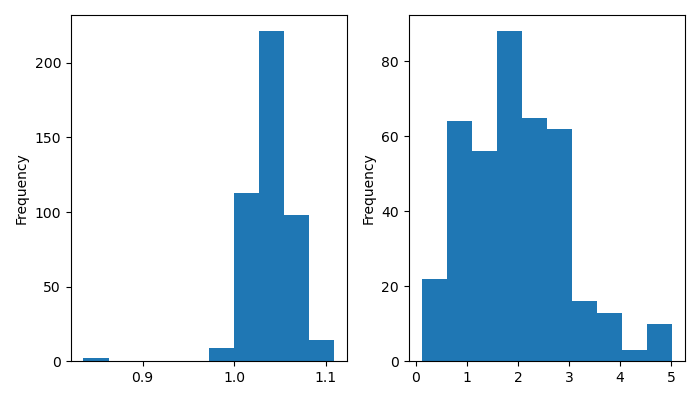

In [237]:
# Merge C1 Hrms with predicted and observed at C6 values
df_c1 = (0.5 * np.sqrt(2) * dss.Hm0).to_dataframe()
df_c1 = df_c1.rename(columns={'Hm0':'Hrms_in'})
df_c1 = df_c1['Hrms_in'].to_frame()
# df = df.merge(df_c1, left_on='time', right_on='time')
# Also merge observed dissipation at L1 with C3 observations and predictions
mid = 'L1' # Mooring ID to use
# Vector data root directory
vec_root = os.path.join(rootdir, 'Vectors', 'Level1')
vec_datadir = os.path.join(vec_root, mid)
# diss. rate (epsilon) csv file dir.
eps_dir = os.path.join(vec_datadir, 'dissipation_rate') 
# List all daily csv files in directory, read and concatenate
fns_csv = sorted(glob.glob(os.path.join(eps_dir, 'burst_diss_*.csv')))
dfl = [] # List for concatenating dataframes
for fn in fns_csv:
    # Read into pandas dataframe
    dfb = pd.read_csv(fn, parse_dates=['time']).set_index('time')
    # Append to list for concatenating
    dfl.append(dfb)
# Concatenate observed diss. rate dataframes
do = pd.concat(dfl)
# Only keep eps_phase and rename
do = do['eps_phase'].to_frame()
do = do.rename(columns={'eps_phase':'eps_phase_l1'})
# Merge observed & predicted Hrms timeseries from C6
# dfd = dfd.merge(do, left_on='time', right_on='time')
# Plot histogram of C1 vs. C6 Hrms ratios
fig, axes = plt.subplots(figsize=(7,4), ncols=2)
(df['Hrms_in'] / df['Hrms_obs']).plot.hist(ax=axes[0])
(dfd['eps_phase'] / dfd['eps_phase_l1']).plot.hist(ax=axes[1])

plt.tight_layout()
plt.show()